# MLB Pitching Win Rate Linear Regression Analysis

### Our analysis aims to find out which statistic in baseball, is the most important in determining the win rate of a pitcher in the MLB.  This analysis will only on the aspects of pitching that affect the win rate of a pitcher, and does not include other aspects of the game such as batting and fielding. 

## Importing Key Liabraries

In [1]:
#############################
#          imports          #
#############################

# System #
import pickle
import time

# Libraries for data parsing and manipulation #
from sklearn.utils import shuffle
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import re

# Imports for statistical and regression analysis #
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats as stats
import sklearn as sk
import patsy

# Imports for plotting #
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Random State #
SEED = 888

### Loading our pickled dataframes ...

The data was obtained from MLB stats website (http://m.mlb.com/stats). 

The dataset includes pitcher player data from 1969 to 2019, with 50 observations in each year.

In [3]:
with open('mlb_stats.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

### First and foremost,  we need to do some basic cleaning of our data!

We will be renaming the column headers, dropping columns that are not required for our analysis and ensuring that the datatypes are correct for each column. 

In [4]:
# Creating a list of column names #
headers = ['rank', 'player', 'team,', 'blank_1', 'blank_2', 'wins', 'losses', 'ERA', 'games', 'games_started', 'saves',
           'save_opportunities', 'innings_pitched', 'hits_allowed', 'runs_allowed', 'earned_runs', 'homeruns_allowed',
           'walks', 'strikeouts', 'batting_average', 'WHIP', 'complete_games', 'shutouts', 'hits_batsman', 'intentional_walk',
           'games_finished', 'holds', 'double_plays', 'groundouts', 'airouts', 'wild_pitches', 'illegal_pitches','stolen_bases',
           'caught_stealing', 'pickoffs', 'total_bases', 'total_pitches', 'GO_AO_ratio', 'on_base_pct','slugging_avg',
           'on_base_plus_slugging', 'strikeouts_per_9_innings', 'balls_per_9_innings','hits_per_9_innings',
           'strikeouts_to_balls', 'pitching_per_inning', 'win_percentage']

In [5]:
# Changing the column headers #
df.columns = headers

In [6]:
# Dropping columns that contain useless information or are statistics that are unrelated to pitching #
df.drop(['rank', 'player', 'team,', 'blank_1', 'blank_2', 'wins', 'losses', 'batting_average', 'stolen_bases',
         'caught_stealing', 'total_bases', 'on_base_pct', 'slugging_avg', 'on_base_plus_slugging'], axis=1, inplace=True)

In [7]:
# Checking the datatypes #
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 33 columns):
ERA                         2550 non-null object
games                       2550 non-null object
games_started               2550 non-null object
saves                       2550 non-null object
save_opportunities          2550 non-null object
innings_pitched             2550 non-null object
hits_allowed                2550 non-null object
runs_allowed                2550 non-null object
earned_runs                 2550 non-null object
homeruns_allowed            2550 non-null object
walks                       2550 non-null object
strikeouts                  2550 non-null object
WHIP                        2550 non-null object
complete_games              2550 non-null object
shutouts                    2550 non-null object
hits_batsman                2550 non-null object
intentional_walk            2550 non-null object
games_finished              2550 non-null object
holds      

Upon verification with the website from which we obtained the data, all of the data columns that we have left are supposed to be numerical. 

As they are currently expressed as dataframe objects, we need to change them to their appropriate datatype.

In [8]:
# Changing all column datatypes to numeric #
df = df.apply(pd.to_numeric, errors='coerce')

In [9]:
# Checking our data again after the transformation #
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 33 columns):
ERA                         2550 non-null float64
games                       2550 non-null int64
games_started               2550 non-null int64
saves                       2550 non-null int64
save_opportunities          2550 non-null int64
innings_pitched             2550 non-null float64
hits_allowed                2550 non-null int64
runs_allowed                2550 non-null int64
earned_runs                 2550 non-null int64
homeruns_allowed            2550 non-null int64
walks                       2550 non-null int64
strikeouts                  2550 non-null int64
WHIP                        2550 non-null float64
complete_games              2550 non-null int64
shutouts                    2550 non-null int64
hits_batsman                2550 non-null int64
intentional_walk            2550 non-null int64
games_finished              2550 non-null int64
holds                  

As our dataset spanned 50 years, there were some variables that were not recorded in earlier periods. Therefore, we decided to drop the columns that have null values. 

In [10]:
# Dropping all columns with null data #
df.dropna(axis='columns', inplace=True)

Rearranging our dependent variable, 'win_percentage' to be the first column.

In [11]:
cols = list(df.columns)
cols = cols[-1:] + cols[:-1]
df = df[cols]

### Having done a basic cleaning of our data, we can now explore the relationship between variables in our dataset. We do so by plotting a correlation matrix heatmap of our variables.

(27.0, 0.0)

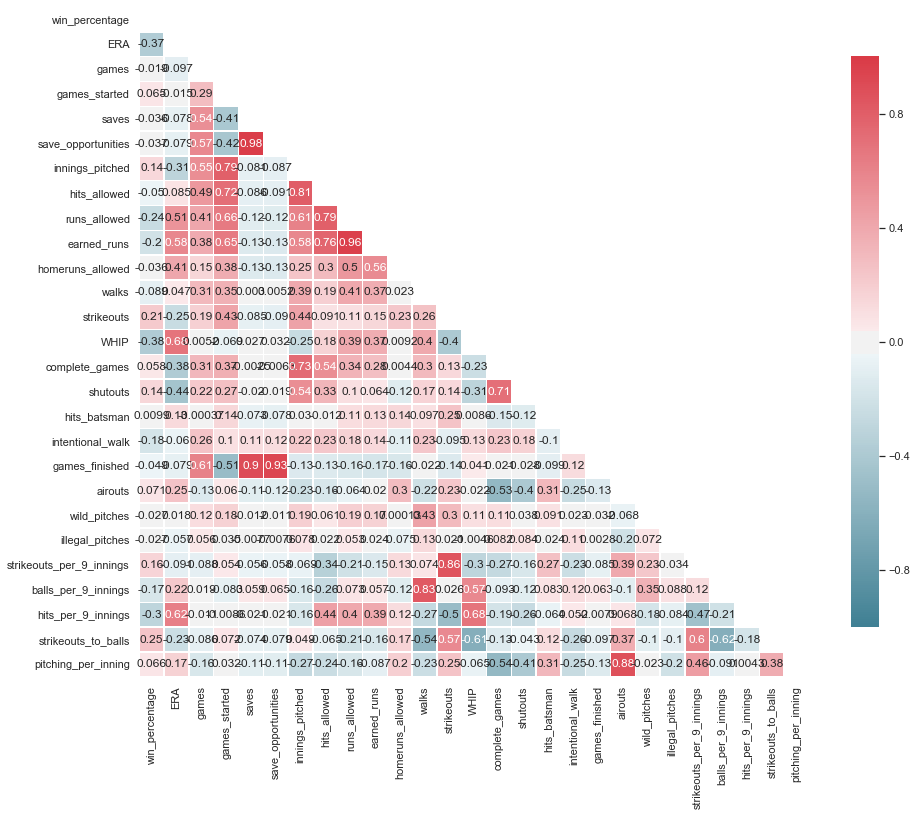

In [12]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7}, annot=True)

bottom, top = ax.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)

### The heatmap shows that we have multiple pairs of highly correlated variables. Therefore, we will be dropping the variables that have their information capture by other variables or are a function of multiple variables.

1. Dropping __`games_started`__ and __`games`__ as their info are captured in __`innings_pitched`__.
2. Dropping __`ERA`__ as it is a combination of two different variables, __`earned_runs`__ and __`innings_pitched`__.
3. Dropping __`save_opportunities`__ as its info is already captured in __`saves`__.
4. Dropping __`runs_allowed`__ as most of its information is already captured in __`earned_runs`__.
5. Dropping __`complete_games`__ and __`games_finshed`__ as their information is mostly captured in __`shutouts`__.
6. Dropping all variables that are the __average of 9 innings__. 
7. Dropping __`WHIP`__ as it is a combination of the three variables, __`walks`__, __`hits`__ and __`innings_pitched`__.

In [13]:
df.drop(['ERA', 'games', 'games_started', 'save_opportunities', 'runs_allowed', 'hits_allowed','complete_games',
         'games_finished', 'WHIP', 'strikeouts_per_9_innings','balls_per_9_innings', 'hits_per_9_innings',
         'strikeouts_to_balls'], axis=1, inplace=True)

### Checking the correlation matrix heatmap after dropping the variables.

(14.0, 0.0)

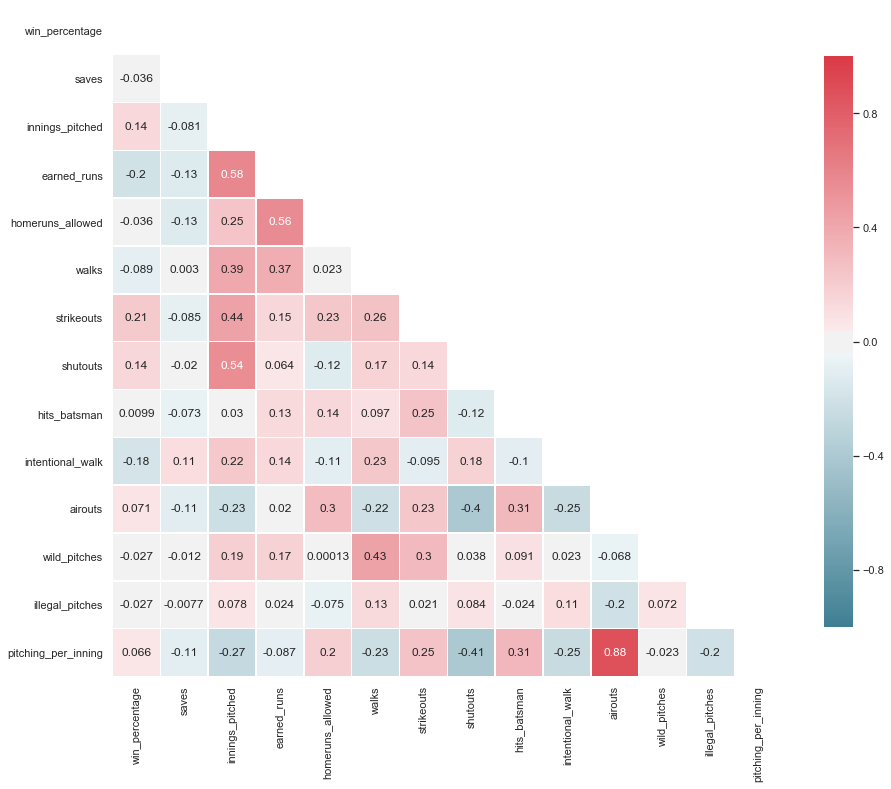

In [14]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7}, annot=True)

bottom, top = ax.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)

Dropping the aforementioned variables has removed most of the multicollinerity between variables, alibeit the pair of airouts and pitching_per_inning which we will continue to monitor. 

From our data, it also seams that we do not have any variables that are highly correlated to our dependent variable. 

Therefore, we will check the distribution for our independent variables and attempt transformation to see if it improves the
relationship with the dependent variable.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d11471d90>,
      dtype=object)

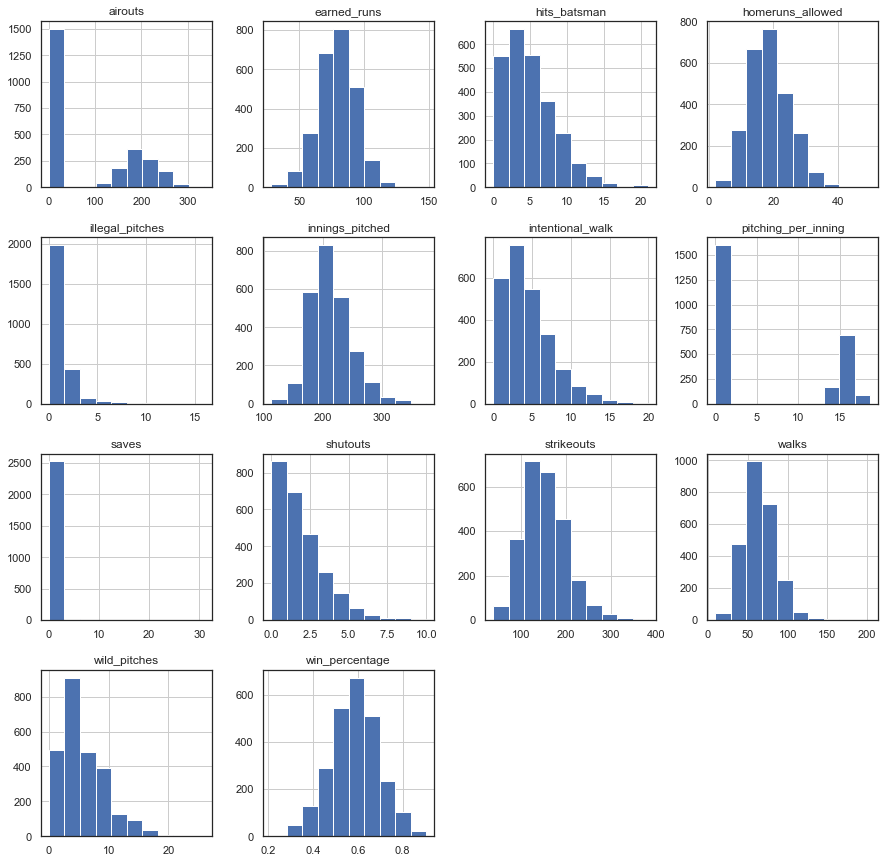

In [15]:
pd.DataFrame.hist(df, figsize = [15,15])

From the  historgrams, we will be dropping the variables air_outs and pitches_per_inning as they appear to be a new statistic
that was not used in the earlier years of baseball. We will also be dropping saves and illegal pitches as majority of players
have recorded 0s for these statistics and is not representative. 

We will be scaling our dependent variable by 100 to express it as a percentage instead.

We will attempt square root transformation on the following variables: shutouts, hits_batsman, intentional walks and wild_pitches.

For the other variables, they appear to be mostly normally distributed, however, we will attempt a log transformation on these
variables and analyse if they have a positive impact on the relationship with the dependent variable. 

In [16]:
df.drop(['airouts', 'pitching_per_inning', 'saves', 'illegal_pitches'], axis=1, inplace=True)

In [17]:
# Scaling our dependent variable to be expressed as a percentage #
df['win_percentage'] = df['win_percentage'] * 100

In [18]:
# Saving our dataframe before transforming our variables #
with open('MLB_clean_dataframe.pickle', 'wb') as file_out:
    pickle.dump(df, file_out)

In [19]:
# Square-root transformation #
df['sqrt_shutouts'] = df['shutouts'] ** (1/2)
df['sqrt_wild_pitches'] = df['wild_pitches'] ** (1/2)
df['sqrt_intent_walk'] = df['intentional_walk'] ** (1/2)
df['sqrt_hits_batsman'] = df['hits_batsman'] ** (1/2)

In [20]:
# Natural logarithm transformation #
df['ln_homeruns_allowed'] = np.log(df['homeruns_allowed'])
df['ln_innings_pitched'] = np.log(df['innings_pitched'])
df['ln_earned_runs'] = np.log(df['earned_runs'])
df['ln_strikeouts'] = np.log(df['strikeouts'])
df['ln_walks'] = np.log(df['walks'])

In [21]:
df.corr()

,win_percentage,innings_pitched,earned_runs,homeruns_allowed,walks,strikeouts,shutouts,hits_batsman,intentional_walk,wild_pitches,sqrt_shutouts,sqrt_wild_pitches,sqrt_intent_walk,sqrt_hits_batsman,ln_homeruns_allowed,ln_innings_pitched,ln_earned_runs,ln_strikeouts,ln_walks
win_percentage,1.000000,0.137742,-0.197693,-0.036159,-0.088732,0.214422,0.143888,0.009874,-0.184387,-0.026777,0.130922,-0.023321,-0.199424,0.006009,-0.035157,0.138363,-0.203991,0.194444,-0.097387
innings_pitched,0.137742,1.000000,0.578346,0.249490,0.393150,0.437411,0.542600,0.030224,0.219779,0.189395,0.507423,0.182626,0.204441,0.044336,0.266144,0.991775,0.562208,0.435522,0.374165
earned_runs,-0.197693,0.578346,1.000000,0.557736,0.374851,0.146255,0.063781,0.130179,0.135878,0.174758,0.074868,0.174398,0.133743,0.139930,0.562804,0.592987,0.987641,0.192295,0.365762
homeruns_allowed,-0.036159,0.249490,0.557736,1.000000,0.023316,0.230668,-0.121809,0.142548,-0.109078,0.000130,-0.132562,0.004651,-0.116417,0.143699,0.963196,0.263391,0.554749,0.264147,0.027957
walks,-0.088732,0.393150,0.374851,0.023316,1.000000,0.264721,0.171192,0.097230,0.226629,0.433632,0.168906,0.426387,0.229484,0.098253,0.041096,0.387160,0.366577,0.274875,0.967489
strikeouts,0.214422,0.437411,0.146255,0.230668,0.264721,1.000000,0.137916,0.254708,-0.095419,0.301372,0.091314,0.300181,-0.114589,0.258882,0.241928,0.441847,0.144386,0.972239,0.242018
shutouts,0.143888,0.542600,0.063781,-0.121809,0.171192,0.137916,1.000000,-0.122518,0.179206,0.038148,0.932200,0.034366,0.178332,-0.123022,-0.120333,0.513758,0.049498,0.109868,0.162715
hits_batsman,0.009874,0.030224,0.130179,0.142548,0.097230,0.254708,-0.122518,1.000000,-0.100070,0.090716,-0.133962,0.095491,-0.101250,0.955265,0.148809,0.038180,0.133383,0.264029,0.091924
intentional_walk,-0.184387,0.219779,0.135878,-0.109078,0.226629,-0.095419,0.179206,-0.100070,1.000000,0.023292,0.174390,0.019140,0.943644,-0.094051,-0.099173,0.213582,0.132356,-0.085993,0.236278
wild_pitches,-0.026777,0.189395,0.174758,0.000130,0.433632,0.301372,0.038148,0.090716,0.023292,1.000000,0.031551,0.960783,0.016852,0.092736,0.000051,0.183548,0.167257,0.302980,0.416514


From the above correlation matrix, we will be keeping the transformed variables that have improved the correlation with the dependent variable and dropping the original variables. 

We will be dropping transformed variables from our model that have lower correlation with the dependent variable as compared to the variable without transformation. 

Additionally, we will be dropping the hits_batman variable as well as its correlation with the dependent variable is extremely low. 

In [22]:
df.drop(['innings_pitched', 'ln_homeruns_allowed', 'ln_strikeouts', 'walks', 'earned_runs', 'sqrt_hits_batsman',
         'sqrt_hits_batsman', 'sqrt_shutouts', 'sqrt_wild_pitches', 'intentional_walk'], axis=1, inplace=True)

(10.0, 0.0)

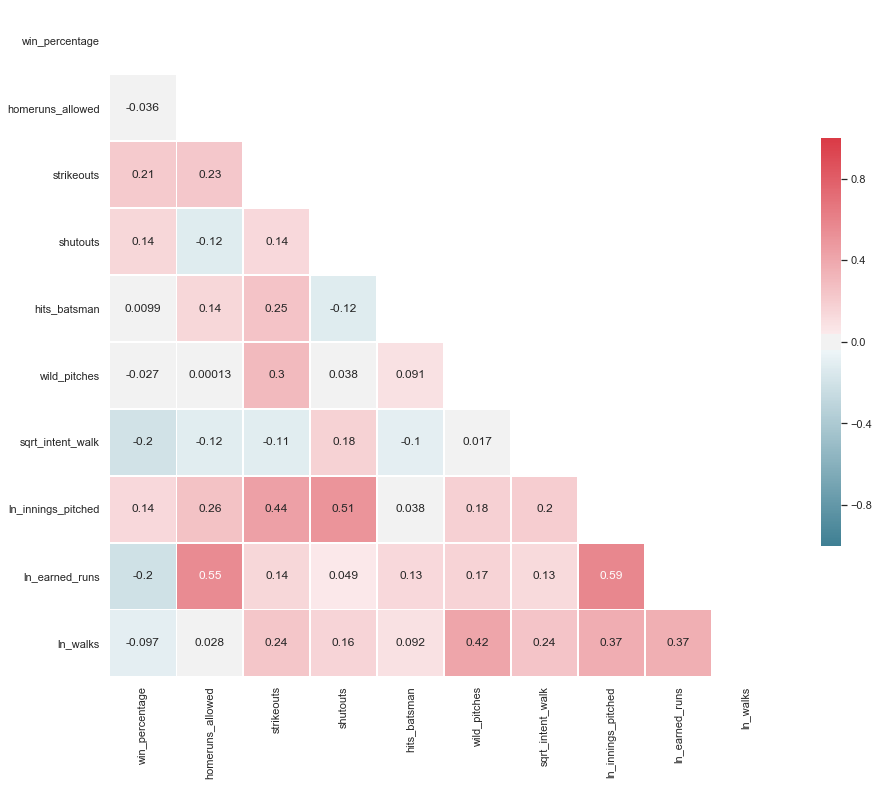

In [23]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

bottom, top = ax.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)

### From the correlation matrix heatmap, it does not appear that we have any serious issues of multicollinearity, therefore we can begin our regression analysis.

## Functions for our regression analysis.

In [24]:
def data_splitter(X, Y):
    '''
    Splits the dataframe into different datasets for training, validation and testing.
    
    Parameters:
        X (dataframe): The dataframe consisting of features which is to be split into training, validation and testing datasets of sample size: 60%, 20% and 20% respectively 
        Y (series): The series which consists of the dependent variable values. Split in the same proportions as X.
    
    Returns:
        x (array): Array consisting of 80% of the initial X values. 
        x_train (array): Array consisting of 60% of the initial X values. To be used for training models.
        x_valid (array): Array consisting of 20% of the initial X values. To be used for validation of trained models.
        x_test (array): Array consisting of 20% of the initial X values. Only used in the final testing of chosen candidate model.
        
        y (array): Array consisting of 80% of the initial Y values.
        y_train (array): Array consisting of 60% of the initial Y values. To be used for training models.
        y_valid (array): Array consisting of 20% of the initial Y values. To be used for validation of trained models.
        y_test (array): Array consisting of 20% of the initial Y values. Only used in the final testing of chosen candidate model.
        
    '''    
    
    # Creating overall training and test splits for both dependent and independent variables #
    x, x_test, y, y_test = train_test_split(X, Y, test_size=0.2, random_state=8)
    
    # Splitting our overall training dataset into model training and validation datasets #
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=8)
    
    return x, x_train, x_valid, x_test, y, y_train, y_valid, y_test

In [25]:
def standardiser(x, x_testing):
    ''' 
    Function to standardise our data.
    
    Parameters:
        x (array): Array consisting of your training dataset. Values are used to obtain the mean and standard deviation for the standard scaling.
        x_testing (array): Array consisting of your testing dataset. Validation dataset is used unless performing final model test.
    
    Returns:
        x_scaled (array): Array of values in which each feature column for the training dataset has been standardised.  
        x_testing_scaled (array): Array of values in which each feature column for the testing dataset has been standardised. 
        
    '''
    
    scaler = StandardScaler() 
    scaler.fit(x.values) # Obtaining the mean and std deviation from the fitted values #
    
    # Standardising our independent values #
    x_scaled = scaler.transform(x.values)
    x_testing_scaled = scaler.transform(x_testing.values)
    
    return x_scaled, x_testing_scaled

In [26]:
def lin_reg_model(x_vals, y_vals):
    '''Fitting a simple linear regression model using statsmodels, and displaying the summary statistics.
    
    Parameters:
        x_vals (array-like): Array of independent variables and their values to fit the model.
        y_vals (array-like): Array of dependent variable values.
        
    Returns:
        Summary statistics of the model fitted.
        
    '''
    x_vals = sm.add_constant(x_vals) # Adding an intercept to our model #
    model = sm.OLS(y_vals, x_vals) 
    results = model.fit() # Fitting the model #
    
    return results.summary()

In [27]:
def adj_r_square(x, model_r2):
    '''
    Calculates the adjusted R-Square of the model.
    
    Parameters:
        x (array): Array of independent variables' values.
        model_r2 (float): R-Square of the model fitted on the same array x as the independent variables.
        
    Returns:
        adj_r2 (float): Adjusted R-Square of the model fitted. 
        
    '''
    n = x[:].size # Number of observations #
    k = x[0].size # Number of parameters # 
    adj_r2 = 1 - (1-model_r2) * ((n-1)/(n-k-1))
    
    return adj_r2

In [28]:
def rmse(y_true, y_pred):
    '''
    Calculates the Root Mean Squared Error (RMSE) of the model.
    
    Parameters:
        y_true (array): Actual depenedent variable values.
        y_pred (array): Values predicted by the model.
    
    Returns:
        root_mse (float): Root Mean Square Error of the model.
        
    '''
    
    squared_errors = (y_true - y_pred) ** 2 
    mean_squared_errors = np.mean(squared_errors)
    root_mse = np.sqrt(mean_squared_errors)
    
    return root_mse

In [29]:
def model_diagnostic_plots(y_hat, model_residuals, model_type):
    '''
    Plots the distribution of the residuals against the predicted y-values and the Q-Q plot to check for normality of the model residuals.
    
    Parameters:
        y_hat (array): Predicted values of the model.
        model_residuals (array): Difference between the actual and predicted y-values.
        model_type (str): Type of model the graphs are being plotted for. 
        
    '''
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,2,1)
    plt.scatter(y_hat, model_residuals)
    plt.title('{} Residual Plot'.format(model_type), fontsize=14)
    plt.xlabel('Predicted y-values', fontsize=12)
    plt.ylabel('Residuals', fontsize=12) 
    
    plt.subplot(1,2,2)
    stats.probplot(model_residuals, dist='norm', plot=plt)
    plt.title('{} Normal Q-Q Plot'.format(model_type), fontsize=14)

In [30]:
# Creating dictionaries to store the results of our K-Fold Cross Validation #
lin_reg_cv_metrics = {}

ridge_cv_metrics = {}

lasso_cv_metrics = {}

models = {}

In [31]:
def kfold_linreg(x, y, seed, plot=True, show_res=True):
    '''
    Performs a K-Fold cross validation linear regression and stores the evaluation metrics in a dictionary.
    Also graphs the diagnostic plots to check the model's residuals.
    
    Parameters:
        x (array): N-dimensional array of features to be split into training and validation datasets.
        y (array): Array of the target which is to be split into training and validation datasets.
        seed (int): Seed that all functions are using for the random state. 
        
    Returns:
        lr_score (float): Average R-Sqared from the cross validation linear regression model. 
        lr_adj_r2 (float): Average Adjusted R-Sqared from the cross validation linear regression model.
        lr_rmse (float): Average Root-Mean-Squared-Error from the cross validation linear regression model.
    
    '''
    lin_reg_scores = []
    lin_reg_adj_r2 = []
    lin_reg_rmse = []
    
    x = np.array(x) 
    y = np.array(y)
    
    # KFolds instructions #
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    # Linear Regression KFolds Cross Validation #
    for training_index, validation_index in kf.split(x, y):
        x_training, y_training = x[training_index], y[training_index]
        x_validation, y_validation = x[validation_index], y[validation_index]
    
        # Testing on validation dataset #
        lin_reg = LinearRegression()
        lin_reg.fit(x_training, y_training)
        lin_reg_y_hat = lin_reg.predict(x_validation) # Predicted y values from the model #

        # Saving the R-Square from testing on the validation data #
        lin_reg_scores.append(lin_reg.score(x_validation, y_validation)) 
        # Calling the RMSE function and appending the returned rmse of the model to a list #
        lin_reg_rmse.append(rmse(y_validation, lin_reg_y_hat)) 
        # Calling the Adjusted R-Square Function and appending the results to a list #
        lin_reg_adj_r2.append(adj_r_square(y_validation, lin_reg.score(x_validation, y_validation)))
        
    # Fitting data for diagnostic plots #
    lr = LinearRegression()
    lr.fit(x,y)
    lr_resid = y - lr.predict(x)
    
    if plot==True:
        model_diagnostic_plots(lr.predict(x), lr_resid, 'Linear Regression')
        
    lr_score = np.mean(lin_reg_scores)
    lr_adj_r2 = np.mean(lin_reg_adj_r2)
    lr_rmse = np.mean(lin_reg_rmse)
    
    if show_res == True:
        lin_reg_cv_metrics['R-Squared'] = lr_score
        lin_reg_cv_metrics['Adjusted R-Squared'] = lr_adj_r2
        lin_reg_cv_metrics['RMSE'] = lr_rmse  

        print(lin_reg_cv_metrics)
    
    return lr_score, lr_adj_r2, lr_rmse

In [41]:
def kfold_ridge(x, y, x_testing, y_testing, k, seed, plot=True, show_res=True):
    '''
    Performs a KFold cross validation for a Ridge regression model.
    
    Parameters:
        x (array-like): Independent variables' values of your training dataset.
        y (array_like): Values for the dependent variables of your training dataset.
        x_testing (array_like): Independent variables' values of your testing dataset. Validation dataset is used unless performing final model test.
        y_testing (array_like): Values for the dependent variables of your testing dataset. Validation dataset is used unless performing final model test.
        k (int): Number of folds for cross validation.
        seed (int): Seed that all functions are using for the random state.  
        
    Returns:
        ridge_score (float): R-Sqared from testing the cross validation Ridge regression model on testing dataset. 
        ridge_adj_r2 (float): Adjusted R-Sqared from testing the cross validation Ridge regression model on testing dataset.
        ridge_rmse (float): Root-Mean-Squared-Error from testing the cross validation Ridge regression model on testing dataset.
        
    ''' 
    # Standardising our data #
    x , x_testing = standardiser(x, x_testing) # Returns x_scaled and x_testing_scaled
    
    # Changing our dataframes to numpy arrays for sklearn to parse #
    x, x_testing = np.array(x), np.array(x_testing)
    y, y_testing = np.array(y), np.array(y_testing)
    
    # Ridge Regression KFold Cross Validation #
    ridge_model = RidgeCV(alphas=alpha_vector, cv=k)
    ridge_model.fit(x, y) # Fitting the model with parameters from training dataset
    
    ridge_y_hat = ridge_model.predict(x_testing) # Obtaining the predicted values from the LASSO regression #
    ridge_residuals = y_testing - ridge_y_hat
    
    if plot == True:
        model_diagnostic_plots(ridge_y_hat, ridge_residuals, 'Ridge Regression')

    ridge_score = ridge_model.score(x_testing, y_testing)
    ridge_adj_r2 = adj_r_square(x_testing, ridge_model.score(x_testing, y_testing))
    ridge_rmse = rmse(y_testing, ridge_y_hat)
    
    if show_res == True:
        ridge_cv_metrics['R-Squared'] = ridge_score
        ridge_cv_metrics['Adjusted R-Squared'] = ridge_adj_r2
        ridge_cv_metrics['RMSE'] = ridge_rmse 

        print(ridge_cv_metrics)
    
    return ridge_score, ridge_adj_r2, ridge_rmse

In [42]:
def kfold_lasso(x, y, x_testing, y_testing, k, seed, plot=True, show_res=True):
    '''
    Performs a KFold cross validation for a LASSO regression model.
    
    Parameters:
        x (array-like): Independent variables' values of your training dataset.
        y (array_like): Values for the dependent variables of your training dataset.
        x_testing (array_like): Independent variables' values of your testing dataset. Validation dataset is used unless performing final model test.
        y_testing (array_like): Values for the dependent variables of your testing dataset. Validation dataset is used unless performing final model test.
        k (int): Number of folds for cross validation.
        seed (int): Seed that all functions are using for the random state.
        
    Returns:
        lasso_score (float): R-Sqared from testing the cross validation LASSO regression model on testing dataset. 
        lasso_adj_r2 (float): Adjusted R-Sqared from testing the cross validation LASSO regression model on testing dataset.
        lasso_rmse (float): Root-Mean-Squared-Error from testing the cross validation LASSO regression model on testing dataset.
        
    '''
    # Standardising our data #
    x , x_testing = standardiser(x, x_testing) # Returns x_scaled and x_testing_scaled
    
    # Changing our dataframes to numpy arrays for sklearn to parse #
    x, x_testing = np.array(x), np.array(x_testing)
    y, y_testing = np.array(y), np.array(y_testing)
    
    # lASSO Regression KFold Cross Validation #
    lasso_model = LassoCV(alphas=alpha_vector, cv=k, random_state=seed)
    lasso_model.fit(x, y) # Fitting the model with parameters from training dataset
    
    lasso_y_hat = lasso_model.predict(x_testing) # Obtaining the predicted values from the LASSO regression #
    lasso_residuals = y_testing - lasso_y_hat
    
    if plot == True:
        model_diagnostic_plots(lasso_y_hat, lasso_residuals, 'LASSO Regression')
    
    lasso_score = lasso_model.score(x_testing, y_testing)
    lasso_adj_r2 = adj_r_square(x_testing, lasso_model.score(x_testing, y_testing))
    lasso_rmse = rmse(y_testing, lasso_y_hat)
    
    if show_res == True:
        lasso_cv_metrics['R-Squared'] = lasso_score
        lasso_cv_metrics['Adjusted R-Squared'] = lasso_adj_r2
        lasso_cv_metrics['RMSE'] = lasso_rmse

        print(lasso_cv_metrics)
    
    return lasso_score, lasso_adj_r2, lasso_rmse

In [34]:
def model_comparison():
    '''Prints the results of the three models.'''
    print('{}\n{}\n{}'.format(lin_reg_cv_metrics , lasso_cv_metrics, ridge_cv_metrics))

In [47]:
def model_results():
    '''Saves the model results into a dictionary and diaplays them.'''
    
    lr_model_results['R-Squared'] = np.mean(lr_model_scores)
    lr_model_results['Adjusted R-Squared'] = np.mean(lr_model_adj_r2)
    lr_model_results['RMSE'] = np.mean(lr_model_rmse)

    ridge_model_results['R-Squared'] = np.mean(ridge_model_scores)
    ridge_model_results['Adjusted R-Squared'] = np.mean(ridge_model_adj_r2)
    ridge_model_results['RMSE'] = np.mean(ridge_model_rmse)

    lasso_model_results['R-Squared'] = np.mean(lasso_model_scores)
    lasso_model_results['Adjusted R-Squared'] = np.mean(lasso_model_adj_r2)
    lasso_model_results['RMSE'] = np.mean(lasso_model_rmse)

    print('{}\n{}\n{}'.format(lr_model_results, ridge_model_results, lasso_model_results))

### Creating a dataframe and series for our independent and dependent variables respectively.

In [35]:
# X contains the independent variables and Y contains the dependent variables #
X , Y = df.drop('win_percentage', axis=1) , df['win_percentage']

In [36]:
# Using the data_splitter function to split our data into training, validation and testing datasets. #
x, x_train, x_valid, x_test, y, y_train, y_valid, y_test = data_splitter(X, Y)

# Function returns:
# x --> 80% of main dataset, x_train --> 60% of dataset, x_valid --> 20% of dataset and x_testing --> 20% of dataset #
# y --> 80% of main dataset, y_train --> 60% of dataset, y_valid --> 20% of dataset and y_testing --> 20% of dataset #

Pickling our data...

In [37]:
with open('mlb_independent_variables.pickle', 'wb') as file_out:
    pickle.dump(X, file_out)

In [38]:
with open('mlb_dependent_variables.pickle', 'wb') as file_out:
    pickle.dump(Y, file_out)

## Feature Selection Methodology

__Method 1)__ `LASSO Regression` for feature selection. Drop variables whose __coefficient__ from the LASSO regression is __0__. 

__Method 2)__ `Backwards Stepwise Regression` for feature selection. Drop the __least statistically significant variable__ (largest t-statistic) and run the regression again. __Repeat the process__ until __all variables are statisitically significant at the 5% level__.

Once the features have been selected using the two models, we will run a __5-Fold Cross Validated__ regression of three models: __(i) Linear Regression (ii) Ridge Regression and (iii) LASSO Regression__. We will then compare the final models selected from the two methods and choose a candidate model which performs the best.

The models will be chosen based on their R-Square, Adjusted R-Square, Root Mean Squared Error and the normality of the model residuals.

## Method 1) LASSO Regression for feature selection.

In [39]:
# Our data has already been split into train, valid and test. This step is to standardise our data.
x_scaled, x_testing_scaled = standardiser(x_train, x_valid) 

# Returns x_scaled and x_testing_scaled

In [40]:
alpha_vector = 10 ** (np.linspace(-3,2,1000)) # Creating an array of alphas for the LASSO regression to loop through #

lasso_reg = LassoCV(alphas=alpha_vector, cv=5, random_state=SEED) # 5-fold cross validated LASSO regression
lasso_reg.fit(x_scaled, y_train) # Fitting the model #

list(zip(x_train.columns, lasso_reg.coef_)) # Printing the coefficients of the LASSO regression #

[('homeruns_allowed', 0.5425982181763492),
 ('strikeouts', 0.9455559125391382),
 ('shutouts', 0.34464854830037434),
 ('hits_batsman', 0.2994401870443028),
 ('wild_pitches', -0.3397821460213894),
 ('sqrt_intent_walk', -2.0712596228750426),
 ('ln_innings_pitched', 4.095967473641056),
 ('ln_earned_runs', -4.790375287513502),
 ('ln_walks', -0.7309935428889168)]

From the LASSO regression, all our variables are deemed to be significant. Therefore, we will now run test compare the results of three different models on the current set of predictor variables.

{'R-Squared': 0.196518056036227, 'Adjusted R-Squared': 0.19453903646981374, 'RMSE': 9.702769966969772}
{'R-Squared': 0.18585622624591003, 'Adjusted R-Squared': 0.18425638040228842, 'RMSE': 9.646708950440395}
{'R-Squared': 0.1855940722440711, 'Adjusted R-Squared': 0.18399371125066422, 'RMSE': 9.648261943837948}


(0.1855940722440711, 0.18399371125066422, 9.648261943837948)

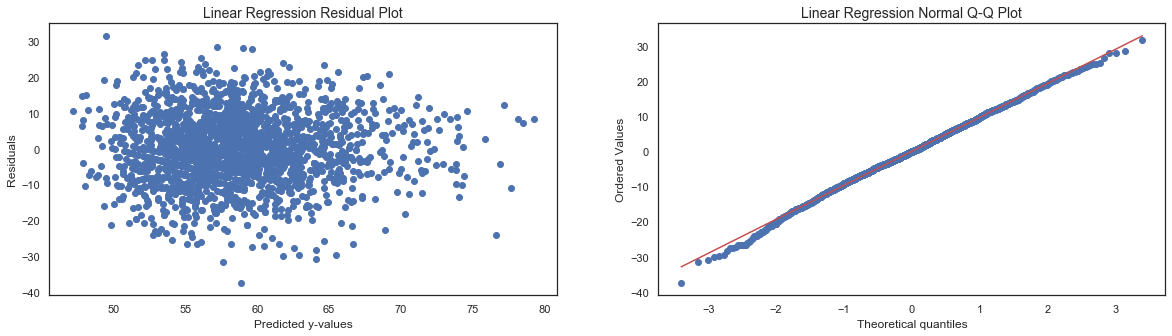

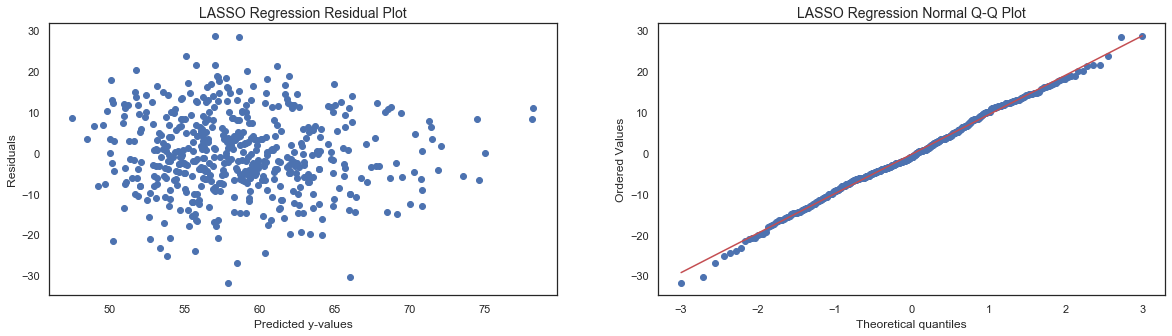

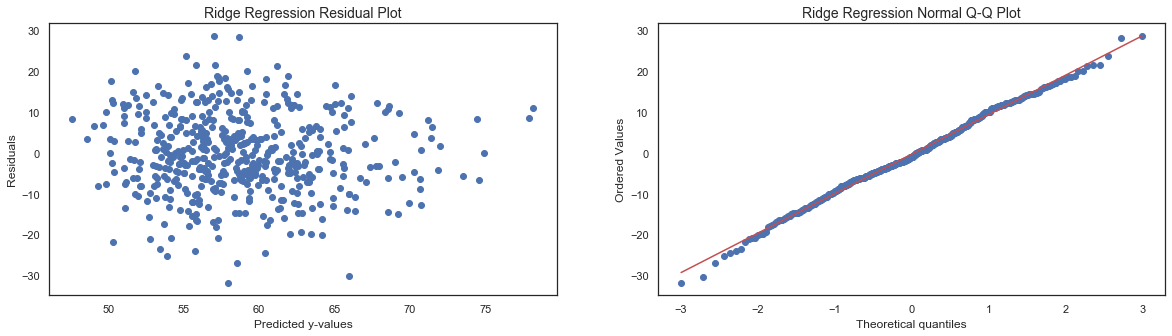

In [43]:
kfold_linreg(x, y, SEED)
kfold_lasso(x_train, y_train, x_valid, y_valid, 5, SEED)
kfold_ridge(x_train, y_train, x_valid, y_valid, 5, SEED)

All three models produced residual plots that appear to be normally distributed. Comparing the results of the three models, the Simple Linear Regression model outperformed the Ridge and LASSO regression models in terms of R-Square and Adjusted R-Square by approximately 1% albeit having a slightly higher Root Mean Squared Error. As the results of the three models are quite close, we will fit all three models again on the full training set and assess their performance on the test dataset. We will compare their average results from 10 simulations.

In [49]:
import random
random_seeds = [53,23523,45,2465,452,51468,789,456,21,959595]

lr_model_scores = []
lr_model_adj_r2 = []
lr_model_rmse = []

ridge_model_scores = []
ridge_model_adj_r2 = []
ridge_model_rmse = []

lasso_model_scores = []
lasso_model_adj_r2 = []
lasso_model_rmse = []

for seed in random_seeds:
    
    lin_reg_score, lin_reg_adj_r2, lin_reg_rmse = kfold_linreg(x, y, seed, plot=False, show_res=False)
    
    lr_model_scores.append(lin_reg_score)
    lr_model_adj_r2.append(lin_reg_adj_r2)
    lr_model_rmse.append(lin_reg_rmse)
    
    lasso_score, lasso_adj_r2, lasso_rmse = kfold_lasso(x_train, y_train, x_valid, y_valid, 5, seed, plot=False, show_res=False)
    
    lasso_model_scores.append(lasso_score)
    lasso_model_adj_r2.append(lasso_adj_r2)
    lasso_model_rmse.append(lasso_rmse) 
    
    ridge_score, ridge_adj_r2, ridge_rmse = kfold_ridge(x_train, y_train, x_valid, y_valid, 5, seed, plot=False, show_res=False)
    
    ridge_model_scores.append(ridge_score)
    ridge_model_adj_r2.append(ridge_adj_r2)
    ridge_model_rmse.append(ridge_rmse)

In [50]:
lr_model_results = {}
lasso_model_results = {}
ridge_model_results = {}

model_results()

{'R-Squared': 0.19582867942379573, 'Adjusted R-Squared': 0.1938479618854307, 'RMSE': 9.711355512060235}
{'R-Squared': 0.18559407224407112, 'Adjusted R-Squared': 0.18399371125066422, 'RMSE': 9.648261943837948}
{'R-Squared': 0.18585622624591003, 'Adjusted R-Squared': 0.1842563804022884, 'RMSE': 9.646708950440395}


The results above show that the Simple Linear Regression has outperformed both the Ridge and LASSO Regression modles in all thee metrics. Therefore, the candidate model selected from LASSO Regression feature selection is the following Linear Regression Model with the following 9 features:

1. Homeruns Allowed
2. Strikeouts
3. Shutouts
4. Hits Batsman
5. Wild Pitches
6. √(Intentional Walks)
7. ln(Innings Pitched)
8. ln(Earned Runs)
9. ln(Walks)

### Second Feature Selection Method: Backwards Stepwise Regression

In [70]:
# Using the data_splitter function to split our data into training, validation and testing datasets. #
x, x_train, x_valid, x_test, y, y_train, y_valid, y_test = data_splitter(X, Y)

# Function returns:
# x --> 80% of main dataset, x_train --> 60% of dataset, x_valid --> 20% of dataset and x_testing --> 20% of dataset #
# y --> 80% of main dataset, y_train --> 60% of dataset, y_valid --> 20% of dataset and y_testing --> 20% of dataset #

In [71]:
lin_reg_model(x_train, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         win_percentage   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     45.65
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           5.20e-73
Time:                        16:21:24   Log-Likelihood:                -5643.3
No. Observations:                1530   AIC:                         1.131e+04
Df Residuals:                    1520   BIC:                         1.136e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 38.2806     10.448      3.664      0.000      17.786      58.775
homeruns_allowed       0.0851      0.051      1.676      0.094      -0.014       0.185
strikeouts             0.0196      0.007      2.954      0.003       0.007       0.033
shutouts               0.2224      0.203      1.094      0.274      -0.177       0.621
hits_batsman           0.0917      0.080      1.149      0.251      -0.065       0.248
wild_pitches          -0.0925      0.077     -1.203      0.229      -0.243       0.058
sqrt_intent_walk      -2.3668      0.313     -7.573      0.000      -2.980      -1.754
ln_innings_pitched    25.1242      2.652      9.472      0.000      19.921      30.327
ln_earned_runs       -24.2315      2.065    -11.735      0.000     -28.282     -20.181
ln_walks              -2.2924      0.958     -2.394      0.017      -4.171      -0.414
==============================================================================
Omnibus:                        6.325   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.426
Skew:                          -0.124   Prob(JB):                       0.0402
Kurtosis:                       3.197   Cond. No.                     6.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the output of the linear regression, we will drop the variable 'shutouts' as it is the most statistically insignificant variable.

In [72]:
X2 = X.drop('shutouts', axis =1)

In [73]:
x, x_train, x_valid, x_test, y, y_train, y_valid, y_test = data_splitter(X2, Y)

lin_reg_model(x_train, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         win_percentage   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     51.20
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           1.26e-73
Time:                        16:21:25   Log-Likelihood:                -5643.9
No. Observations:                1530   AIC:                         1.131e+04
Df Residuals:                    1521   BIC:                         1.135e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 32.6218      9.077      3.594      0.000      14.817      50.427
homeruns_allowed       0.0787      0.050      1.562      0.119      -0.020       0.178
strikeouts             0.0188      0.007      2.848      0.004       0.006       0.032
hits_batsman           0.0860      0.080      1.081      0.280      -0.070       0.242
wild_pitches          -0.0957      0.077     -1.245      0.213      -0.246       0.055
sqrt_intent_walk      -2.3565      0.312     -7.543      0.000      -2.969      -1.744
ln_innings_pitched    26.7057      2.224     12.010      0.000      22.344      31.067
ln_earned_runs       -24.7827      2.003    -12.375      0.000     -28.711     -20.855
ln_walks              -2.2455      0.957     -2.347      0.019      -4.122      -0.369
==============================================================================
Omnibus:                        7.163   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.330
Skew:                          -0.133   Prob(JB):                       0.0256
Kurtosis:                       3.210   Cond. No.                     5.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Dropping the 'shutouts' variable had no impact on either R-Square or Adjusted R-Square. From the regression output, we will drop the predictor variable 'wild_pitches' as it is the least statisically significant variable.

In [76]:
X3 = X2.drop('hits_batsman', axis=1)

In [77]:
x, x_train, x_valid, x_test, y, y_train, y_valid, y_test = data_splitter(X3, Y)

lin_reg_model(x_train, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         win_percentage   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     58.34
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           2.83e-74
Time:                        16:22:00   Log-Likelihood:                -5644.5
No. Observations:                1530   AIC:                         1.130e+04
Df Residuals:                    1522   BIC:                         1.135e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 33.3535      9.052      3.684      0.000      15.597      51.110
homeruns_allowed       0.0788      0.050      1.562      0.118      -0.020       0.178
strikeouts             0.0205      0.006      3.191      0.001       0.008       0.033
wild_pitches          -0.0968      0.077     -1.260      0.208      -0.248       0.054
sqrt_intent_walk      -2.3769      0.312     -7.622      0.000      -2.989      -1.765
ln_innings_pitched    26.3335      2.197     11.986      0.000      22.024      30.643
ln_earned_runs       -24.4763      1.983    -12.346      0.000     -28.365     -20.587
ln_walks              -2.2054      0.956     -2.307      0.021      -4.081      -0.330
==============================================================================
Omnibus:                        7.468   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.671
Skew:                          -0.136   Prob(JB):                       0.0216
Kurtosis:                       3.216   Cond. No.                     5.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
X4 = X3.drop('wild_pitches', axis=1)

In [79]:
x, x_train, x_valid, x_test, y, y_train, y_valid, y_test = data_splitter(X4, Y)

lin_reg_model(x_train, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         win_percentage   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     67.77
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           7.20e-75
Time:                        16:22:15   Log-Likelihood:                -5645.3
No. Observations:                1530   AIC:                         1.130e+04
Df Residuals:                    1523   BIC:                         1.134e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 34.1991      9.029      3.788      0.000      16.488      51.910
homeruns_allowed       0.0861      0.050      1.718      0.086      -0.012       0.184
strikeouts             0.0184      0.006      2.965      0.003       0.006       0.031
sqrt_intent_walk      -2.3489      0.311     -7.550      0.000      -2.959      -1.739
ln_innings_pitched    26.6035      2.187     12.165      0.000      22.314      30.893
ln_earned_runs       -24.7233      1.973    -12.529      0.000     -28.594     -20.853
ln_walks              -2.6021      0.903     -2.882      0.004      -4.373      -0.831
==============================================================================
Omnibus:                        7.552   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.733
Skew:                          -0.138   Prob(JB):                       0.0209
Kurtosis:                       3.212   Cond. No.                     5.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Dropping the variable wild_pitches decreased our R-Squared very slightly but adjusted R-Sqaured remained the same. From the new regression results, we see that homeruns_allowed is not statisically significant at the 5% level, therefore, we will drop the variable and observe its impacts on our metrics.

In [80]:
X5 = X4.drop('homeruns_allowed', axis=1)

In [81]:
x, x_train, x_valid, x_test, y, y_train, y_valid, y_test = data_splitter(X5, Y)

lin_reg_model(x_train, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         win_percentage   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     80.63
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           3.28e-75
Time:                        16:22:36   Log-Likelihood:                -5646.8
No. Observations:                1530   AIC:                         1.131e+04
Df Residuals:                    1524   BIC:                         1.134e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 31.6264      8.910      3.550      0.000      14.149      49.103
strikeouts             0.0209      0.006      3.474      0.001       0.009       0.033
sqrt_intent_walk      -2.4282      0.308     -7.887      0.000      -3.032      -1.824
ln_innings_pitched    25.9838      2.158     12.039      0.000      21.750      30.217
ln_earned_runs       -22.7541      1.607    -14.157      0.000     -25.907     -19.601
ln_walks              -2.9163      0.885     -3.296      0.001      -4.652      -1.181
==============================================================================
Omnibus:                        8.083   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.246
Skew:                          -0.147   Prob(JB):                       0.0162
Kurtosis:                       3.208   Cond. No.                     5.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Dropping the variable 'homeruns_allowed' had minimal impact on both our R-Squared and Adjusted R-Sqaured. As all other variables are significant at the 5% level, we will utilise only these variables which will provide us with a more parsimonious model. 

We will now test the performance of our three models on the following dataset.

{'R-Squared': 0.19691752394215473, 'Adjusted R-Squared': 0.1949394882868398, 'RMSE': 9.699749844114999}
{'R-Squared': 0.18494545607523716, 'Adjusted R-Squared': 0.1833435406980266, 'RMSE': 9.652103255009905}
{'R-Squared': 0.18507898483028107, 'Adjusted R-Squared': 0.18347733189166138, 'RMSE': 9.65131258024349}


(0.18507898483028107, 0.18347733189166138, 9.65131258024349)

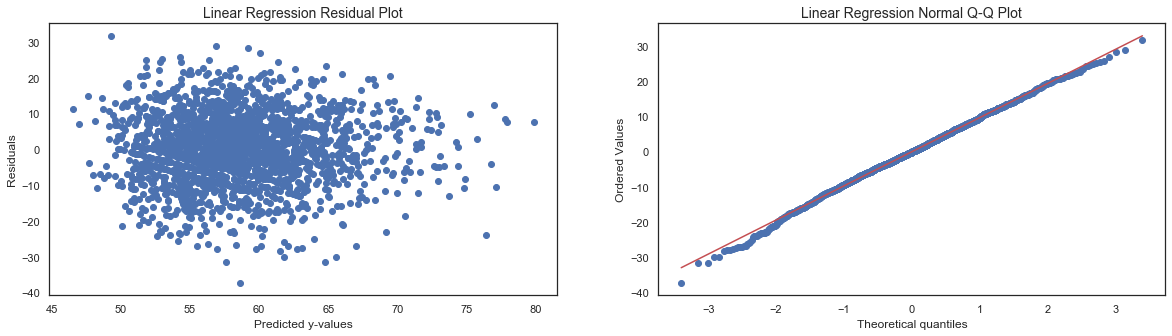

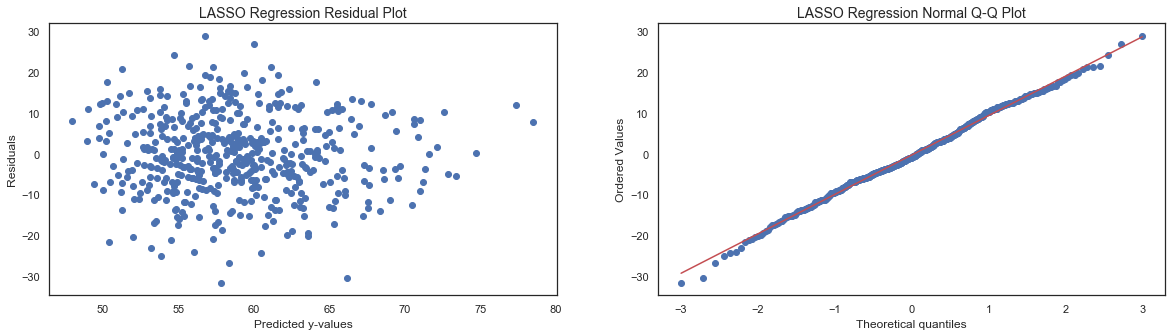

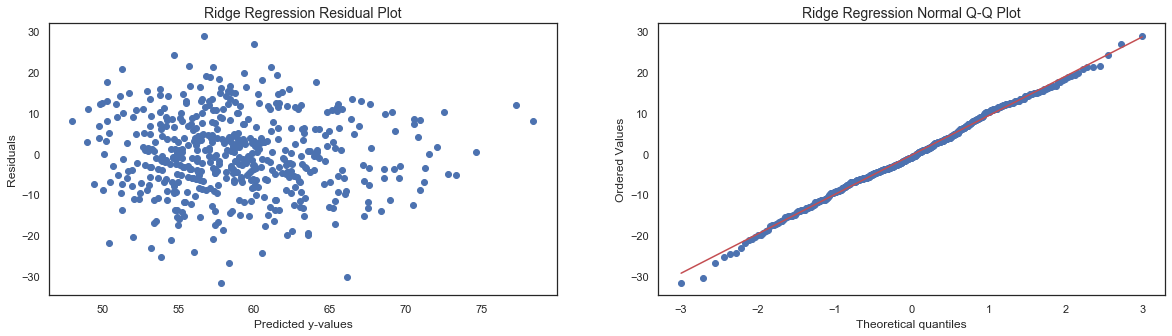

In [82]:
kfold_linreg(x, y, SEED)
kfold_lasso(x_train, y_train, x_valid, y_valid, 5, SEED)
kfold_ridge(x_train, y_train, x_valid, y_valid, 5, SEED)

The Simple Linear Regression Model had  better R-Squared and adjusted R-Squared results as compared to the Ridge and LASSO models. However, it does suffer from a higher Root Mean Squared Error. To account for model variance, we will fit the models with the full training data and compare their average results on the testing data.

In [83]:
random_seeds = [53,23523,45,2465,452,51468,789,456,21,959595]

lr_model_scores = []
lr_model_adj_r2 = []
lr_model_rmse = []

ridge_model_scores = []
ridge_model_adj_r2 = []
ridge_model_rmse = []

lasso_model_scores = []
lasso_model_adj_r2 = []
lasso_model_rmse = []

for seed in random_seeds:
    
    lin_reg_score, lin_reg_adj_r2, lin_reg_rmse = kfold_linreg(x, y, seed, plot=False, show_res=False)
    
    lr_model_scores.append(lin_reg_score)
    lr_model_adj_r2.append(lin_reg_adj_r2)
    lr_model_rmse.append(lin_reg_rmse)
    
    lasso_score, lasso_adj_r2, lasso_rmse = kfold_lasso(x_train, y_train, x_valid, y_valid, 5, seed, plot=False, show_res=False)
    
    lasso_model_scores.append(lasso_score)
    lasso_model_adj_r2.append(lasso_adj_r2)
    lasso_model_rmse.append(lasso_rmse) 
    
    ridge_score, ridge_adj_r2, ridge_rmse = kfold_ridge(x_train, y_train, x_valid, y_valid, 5, seed, plot=False, show_res=False)
    
    ridge_model_scores.append(ridge_score)
    ridge_model_adj_r2.append(ridge_adj_r2)
    ridge_model_rmse.append(ridge_rmse)

In [84]:
lr_model_results = {}
lasso_model_results = {}
ridge_model_results = {}

model_results()

{'R-Squared': 0.19525442929938047, 'Adjusted R-Squared': 0.19327229735184198, 'RMSE': 9.714933642841135}
{'R-Squared': 0.1850789848302811, 'Adjusted R-Squared': 0.18347733189166138, 'RMSE': 9.651312580243488}
{'R-Squared': 0.18494545607523713, 'Adjusted R-Squared': 0.1833435406980266, 'RMSE': 9.652103255009905}


The Simple Linear Model outperformed both the Ridge and LASSO Regression models in terms of explanatory power, having the highest R-Squared and Adjusted R-Squared. As the linear model only suffers from a slightly higher Root-Mean-Squared-Error, therefore, the model selected from Backwards Stepwise Regression will be the Simple Linear Regression model with the following 5 features:

1. Strikeouts
2. √(Intentional Walks)
3. ln(Innings Pitched)
4. ln(Earned Runs)
5. ln(Walks)

### Comparing the models selected from the two feature section methods. 

LASSO Selection (9 Features): 
* R-Squared: 19.58% 
* Adjusted R-Squared: 19.38%
* RMSE: 9.711

Stepwise Selection (5 Features): 
* R-Squared: 19.52% 
* Adjusted R-Squared: 19.32%
* RMSE: 9.715

The candidate model selected from both methods were the Simple Linear Regression models, with the main difference is that the LASSO Regression method selected 9 features while the Backwards Stepwise Regression model selected only 5 features. Comparing the metrics of the two models, the model with 9 features performed better on all metrics, with higher R-Square and Adjusted R-Square and lower Root Mean Squared Errors. However, the difference is very small, with less than 0.06% difference in R-Squared meansures and 0.04 lower RMSE. 

Therefore, although the model with 8 features performed marginally better, our final model will be the model with 5 features, as we believe it is more parsimonious.

## Interpreting the coefficients of the final model.

* Strikeouts: For every unit increase in strikeouts, winning percentage increases by 0.02%.
* Sqrt(Intentional Walks): Intentional walks are negatively related to win rate of pitchers.
* Log(Innings Pitched): For every 1% increase in innings pitched, the winning percent increases by 2.61%.
* Log(Earned Runs): For every 1% increase in the earned runs the pitcher allows, the winning percentage decreases by 2.15%.
* Log(Walks): For every 1% increase in the number of walks the pitcher allows, the winning percentage decreases by 0.25%. 

In [85]:
lin_reg_model(X5,Y)

/home/joshua/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         win_percentage   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     129.1
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          3.79e-122
Time:                        16:34:05   Log-Likelihood:                -9401.2
No. Observations:                2550   AIC:                         1.881e+04
Df Residuals:                    2544   BIC:                         1.885e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 23.9852      6.858      3.498      0.000      10.538      37.432
strikeouts             0.0202      0.005      4.389      0.000       0.011       0.029
sqrt_intent_walk      -2.4918      0.240    -10.391      0.000      -2.962      -2.022
ln_innings_pitched    26.1262      1.657     15.769      0.000      22.877      29.375
ln_earned_runs       -21.5173      1.231    -17.486      0.000     -23.930     -19.104
ln_walks              -2.5356      0.677     -3.743      0.000      -3.864      -1.207
==============================================================================
Omnibus:                        5.214   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                5.175
Skew:                          -0.094   Prob(JB):                       0.0752
Kurtosis:                       3.114   Cond. No.                     5.85e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Insights gained: 

The win rate of the pitcher increases as the number of innings pitched increases,which implies that the pitcher has to pitch more balls over the season. Therefore, top pitchers would not only require the technical skills but also the physicality of being able to throw more balls consistently throughout the season. 

Further analysis of our data showed that the top 10% of pitchers were capable of throwing more than 256 innings per season. For managers, they can use this number as a benchmark when buying players. For coaches, it can be used a a measure to regulate the exhaustion of their pitchers as they approach this number of innings pitched. 

Another insight is that intentional walks have a detrimental impact on the win rate of the pitcher, and by extension, the team as well. Therefore, caution should be made by the coach when calling such a tactical play. 

A walk is when the pitcher throws 4 foul balls and for every 1% increase in the number of walks the pitcher allows, the winning percentage decreases by 0.25%. Furthermore, for every 1% increase in earned run allowed by the pitcher, the win rate decreases by approximately 2.2%. These two statistics show the importance in the pitcher's technical skills as well as his ability to throw consistently.

In [86]:
np.exp(X5.ln_innings_pitched.quantile(0.9))

260.0999999999999

In [87]:
top_pitchers = df.loc[df.win_percentage >= df.win_percentage.quantile(0.9)]

In [88]:
np.exp(top_pitchers.ln_innings_pitched.quantile(0.9))

256.1399953153058